# Fuel consumption dataset

This notebook explores the datasets from  https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64 between 1995 and 2022


# TO DO
Selecting the features can be left to the caller, or can be automated e.g. apply a chi-squared statistical test to rank the impact of each feature on the concept label and discard the less impactful features prior to model training.

In [2]:
import pandas as pd
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import scale
from statsmodels.nonparametric.kde import KDEUnivariate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVC

In [3]:
def box_plot(dataframe, col_list_float, plot_kind):
    """
    This function generates boxplots to show distribution and outliers of various parameters
    """
    
   
    x_val = 1
    y_val = len(col_list_float)
        
    if len(dataframe['model_year'].unique()) ==1:
        title_year = dataframe['model_year'].min()
    else:
        title_year = f'{dataframe["model_year"].min()} - {dataframe["model_year"].max()}'
        
    fig1, axes = plt.subplots(x_val,y_val , sharey=True, figsize=(18,6))
    
    k=0
    for i in range(0,x_val):
        for j in range(0,y_val):

            variable= col_list_float[k].lower()
            if plot_kind=="box":
                sns.boxplot(ax=axes[j], data=dataframe, x=variable)
                fig1.suptitle(f'Outlier identification by vehicle class {title_year}')
            elif plot_kind=="hist":
                sns.histplot(ax=axes[j], data=dataframe, x=variable,bins=10)
                fig1.suptitle(f'Distribution of data {title_year}')
            k+=1
    plt.show()

In [4]:
def find_outliers_tukey(x):
    
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indeces = list(x.index[(x < floor) | (x > ceiling)])
    outlier_values = list(x[outlier_indeces])
    
    return outlier_values

def find_outliers_kde(x):
    x_scaled = scale(list(map(float,x)))
    kde = KDEUnivariate(x_scaled)
    kde.fit(bw='scott',fft=True)
    pred = kde.evaluate(x_scaled)
    
    n = sum(pred<0.05)
    outlier_ind = np.asarray(pred).argsort()[:n]
    outlier_value = np.asarray(x)[outlier_ind]
    
    return outlier_value

### Read data

In [11]:
folder = "C:/Users/Laura GF/Documents/GitHub/machine-learning-capstone/data/"
raw_data = f'{folder}raw-data/'
clean_data = f'{folder}clean-data/'


file_name_2022_1995 = "1995_2022_vehicle_fuel_consumption.csv"

In [20]:


# Master df
master_df = pd.read_csv(Path(folder + "clean-data",f'{file_name_2022_1995}'))

In [25]:
master_df.columns

Index(['model_year', 'make_', 'model.1_', 'vehicleclass_', 'enginesize_(l)',
       'cylinders_', 'transmission_', 'fuel_type',
       'fuelconsumption_city(l/100km)', 'fuelconsumption_hwy(l/100km)',
       'fuelconsumption_comb(l/100km)', 'fuelconsumption_comb(mpg)',
       'co2emissions_(g/km)', 'co2_rating', 'smog_rating',
       'type_of_wheel_drive', 'type_of_transmission', 'type_of_fuel'],
      dtype='object')

## Clean data

In [7]:
master_df.duplicated().sum()

6

In [8]:
master_df[master_df.duplicated()]

,model_year,make_,model.1_,vehicleclass_,enginesize_(l),cylinders_,transmission_,fuel_type,fuelconsumption_city(l/100km),fuelconsumption_hwy(l/100km),fuelconsumption_comb(l/100km),fuelconsumption_comb(mpg),co2emissions_(g/km),co2_rating,smog_rating,type_of_wheel_drive,type_of_transmission,type_of_fuel
379,2000,LAND ROVER,DISCOVERY SERIES II 4X4,SUV,4.0,8.0,A4,Z,19.6,14.9,17.5,16,403,NaN,NaN,unspecified,automatic,premium gasoline
591,1995,NISSAN,AXXESS,MINIVAN,2.4,4.0,A4,X,13.5,10.5,12.2,23,281,NaN,NaN,unspecified,automatic,regular gasoline
593,1995,NISSAN,AXXESS,MINIVAN,2.4,4.0,M5,X,12.6,9.9,11.4,25,262,NaN,NaN,unspecified,manual,regular gasoline
379,2000,LAND ROVER,DISCOVERY SERIES II 4X4,SUV,4.0,8.0,A4,Z,17.7,12.7,15.4,18,354,NaN,NaN,unspecified,automatic,premium gasoline
748,1995,NISSAN,AXXESS,MINIVAN,2.4,4.0,A4,X,12.0,8.9,10.6,27,244,NaN,NaN,unspecified,automatic,regular gasoline
750,1995,NISSAN,AXXESS,MINIVAN,2.4,4.0,M5,X,11.1,8.4,9.9,29,228,NaN,NaN,unspecified,manual,regular gasoline


In [9]:
master_df.drop_duplicates(keep='first', inplace=True)

In [10]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43928 entries, 1 to 3519
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   model_year                     43928 non-null  int64  
 1   make_                          43928 non-null  object 
 2   model.1_                       43928 non-null  object 
 3   vehicleclass_                  43928 non-null  object 
 4   enginesize_(l)                 43928 non-null  float64
 5   cylinders_                     43928 non-null  float64
 6   transmission_                  43928 non-null  object 
 7   fuel_type                      43928 non-null  object 
 8   fuelconsumption_city(l/100km)  43928 non-null  float64
 9   fuelconsumption_hwy(l/100km)   43928 non-null  float64
 10  fuelconsumption_comb(l/100km)  43928 non-null  float64
 11  fuelconsumption_comb(mpg)      43928 non-null  int64  
 12  co2emissions_(g/km)            43928 non-null  

In [11]:
master_df[master_df['co2_rating'].isna()]['model_year'].unique()

array([2015, 2010, 2011, 2012, 2013, 2014, 2005, 2006, 2007, 2008, 2009,
       2000, 2001, 2002, 2003, 2004, 1995, 1996, 1997, 1998, 1999],
      dtype=int64)

#### NaN values in CO2 rating and smog rating columns are due to non-existing ratings between the years 1995 - 2015

In [104]:
master_df.isna().sum()

model_year                           0
make_                                0
model.1_                             0
vehicleclass_                        0
enginesize_(l)                       0
cylinders_                           0
transmission_                        0
fuel_type                            0
fuelconsumption_city(l/100km)        0
fuelconsumption_hwy(l/100km)         0
fuelconsumption_comb(l/100km)        0
fuelconsumption_comb(mpg)            0
co2emissions_(g/km)                  0
co2_rating                       36757
smog_rating                      37867
type_of_wheel_drive                  0
type_of_transmission                 0
type_of_fuel                         0
dtype: int64

In [106]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43928 entries, 1 to 3519
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   model_year                     43928 non-null  int64  
 1   make_                          43928 non-null  object 
 2   model.1_                       43928 non-null  object 
 3   vehicleclass_                  43928 non-null  object 
 4   enginesize_(l)                 43928 non-null  float64
 5   cylinders_                     43928 non-null  float64
 6   transmission_                  43928 non-null  object 
 7   fuel_type                      43928 non-null  object 
 8   fuelconsumption_city(l/100km)  43928 non-null  float64
 9   fuelconsumption_hwy(l/100km)   43928 non-null  float64
 10  fuelconsumption_comb(l/100km)  43928 non-null  float64
 11  fuelconsumption_comb(mpg)      43928 non-null  int64  
 12  co2emissions_(g/km)            43928 non-null  

## Summary stats

In [13]:
master_df.describe()

,model_year,enginesize_(l),cylinders_,fuelconsumption_city(l/100km),fuelconsumption_hwy(l/100km),fuelconsumption_comb(l/100km),fuelconsumption_comb(mpg),co2emissions_(g/km),co2_rating,smog_rating
count,43928.000000,43928.000000,43928.000000,43928.000000,43928.000000,43928.000000,43928.000000,43928.000000,7171.000000,6061.000000
mean,2007.924012,3.393833,5.886655,13.523101,9.566352,11.743018,25.768781,266.098115,4.659880,4.674311
std,7.250467,1.336548,1.779580,3.667994,2.552349,3.127989,7.030849,64.790087,1.638001,1.791209
min,1995.000000,0.800000,2.000000,3.500000,3.200000,3.600000,10.000000,83.000000,1.000000,1.000000
25%,2002.000000,2.300000,4.000000,11.000000,7.800000,9.600000,21.000000,221.000000,4.000000,3.000000
50%,2008.000000,3.200000,6.000000,13.100000,9.100000,11.300000,25.000000,258.000000,5.000000,5.000000
75%,2013.000000,4.300000,8.000000,15.600000,11.000000,13.500000,29.000000,306.000000,6.000000,6.000000
max,2022.000000,8.400000,16.000000,33.300000,22.100000,27.500000,78.000000,633.000000,10.000000,8.000000


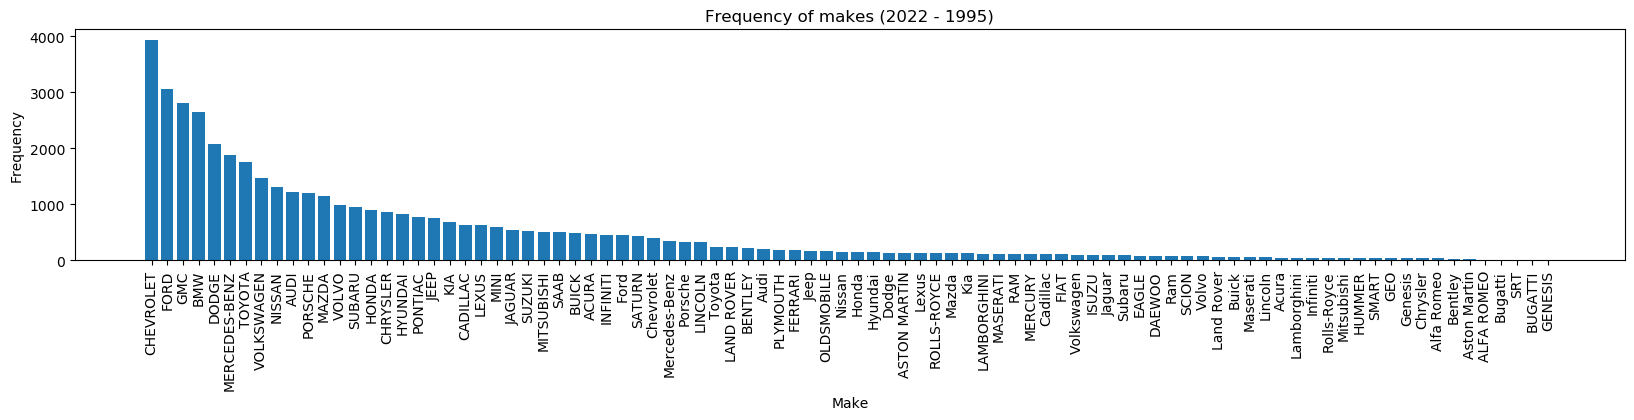

In [14]:
models = master_df.groupby("make_").count()['model_year'].reset_index().rename(columns={"model_year":"count"}).sort_values(by="count", ascending=False)
plt.rcParams["figure.figsize"] = (20,3)
plt.bar(x = models['make_'], height = models['count'])
plt.xticks(rotation=90)
plt.xlabel("Make")
plt.ylabel("Frequency")
plt.title("Frequency of makes (2022 - 1995)")
plt.show()

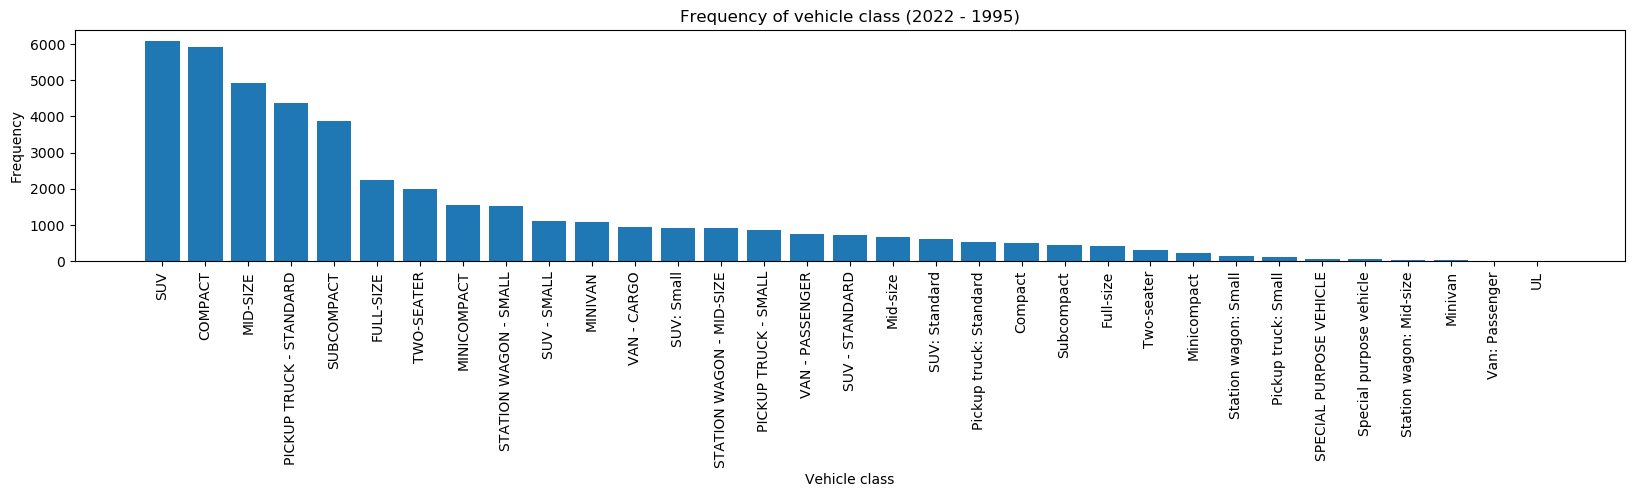

In [15]:
vehicle_class = master_df.groupby("vehicleclass_").count()['model_year'].reset_index().rename(columns={"model_year":"count"}).sort_values(by="count", ascending=False)
plt.rcParams["figure.figsize"] = (20,3)
plt.bar(x = vehicle_class['vehicleclass_'], height = vehicle_class['count'])
plt.xticks(rotation=90)
plt.xlabel("Vehicle class")
plt.ylabel("Frequency")
plt.title("Frequency of vehicle class (2022 - 1995)")
plt.show()

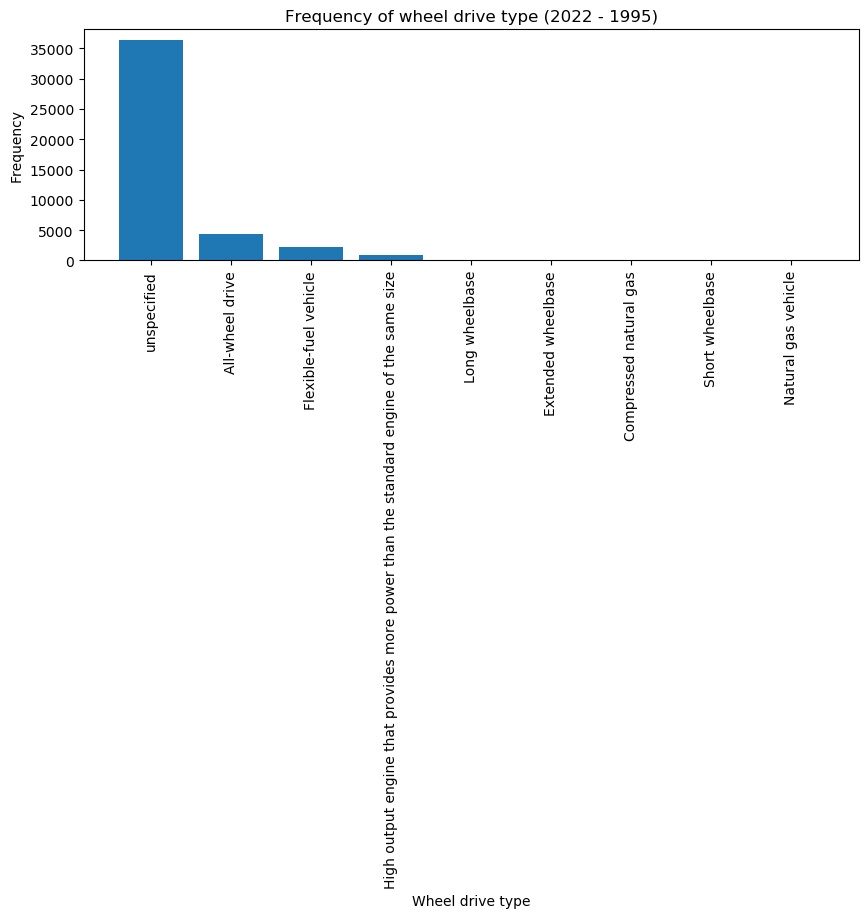

In [16]:
wheel_drive = master_df.groupby("type_of_wheel_drive").count()['model_year'].reset_index().rename(columns={"model_year":"count"}).sort_values(by="count", ascending=False)
plt.rcParams["figure.figsize"] = (10,3)
plt.bar(x = wheel_drive['type_of_wheel_drive'], height = wheel_drive['count'])
plt.xticks(rotation=90)
plt.xlabel("Wheel drive type")
plt.ylabel("Frequency")
plt.title("Frequency of wheel drive type (2022 - 1995)")
plt.show()

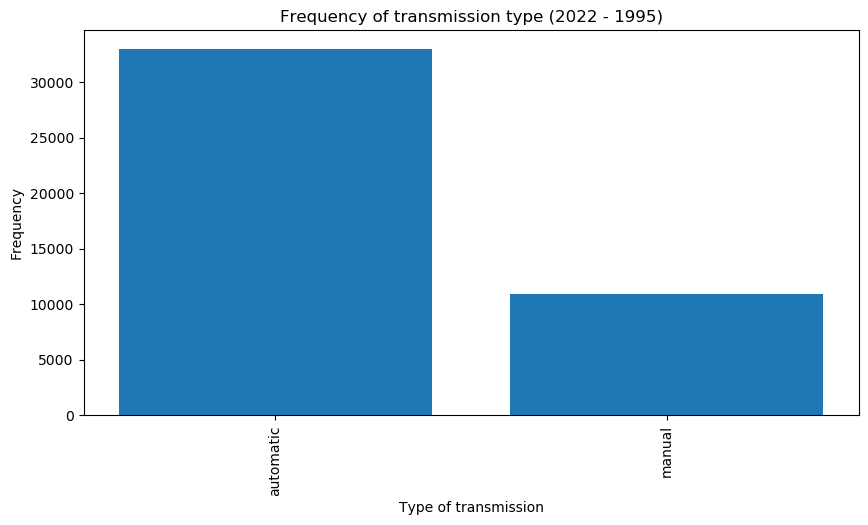

In [17]:
transmission = master_df.groupby("type_of_transmission").count()['model_year'].reset_index().rename(columns={"model_year":"count"}).sort_values(by="count", ascending=False)
plt.rcParams["figure.figsize"] = (10,5)
plt.bar(x = transmission['type_of_transmission'], height = transmission['count'])
plt.xticks(rotation=90)
plt.xlabel("Type of transmission")
plt.ylabel("Frequency")
plt.title("Frequency of transmission type (2022 - 1995)")
plt.show()

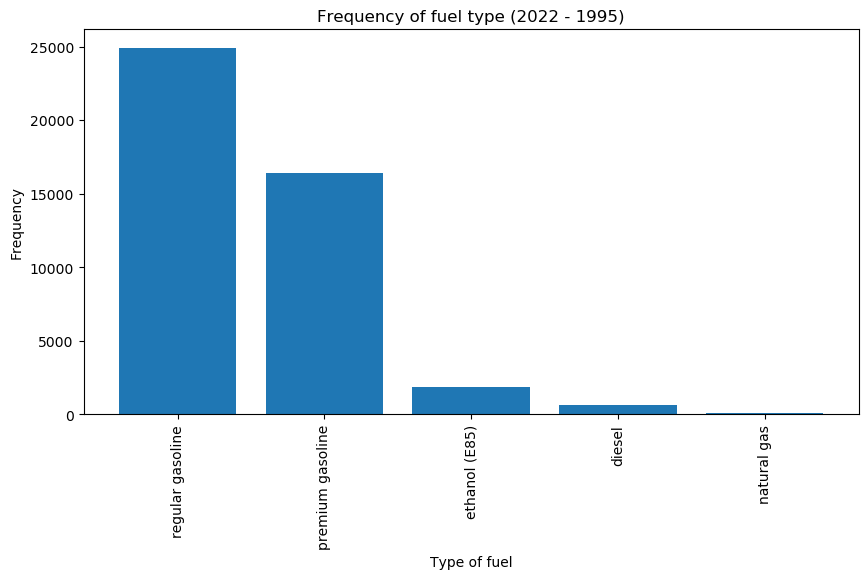

In [18]:
fuel_type = master_df.groupby("type_of_fuel").count()['model_year'].reset_index().rename(columns={"model_year":"count"}).sort_values(by="count", ascending=False)
plt.rcParams["figure.figsize"] = (10,5)
plt.bar(x = fuel_type['type_of_fuel'], height = fuel_type['count'])
plt.xticks(rotation=90)
plt.xlabel("Type of fuel")
plt.ylabel("Frequency")
plt.title("Frequency of fuel type (2022 - 1995)")
plt.show()

### Outliers and scaling

In [19]:


fuel_info = [
              'fuelconsumption_city(l/100km)','fuelconsumption_hwy(l/100km)',	
              'fuelconsumption_comb(l/100km)','fuelconsumption_comb(mpg)',
                  ]     

engine_info  = ['enginesize_(l)','cylinders_','co2_rating','co2emissions_(g/km)','smog_rating']

In [20]:
outliers = {}
for item in fuel_info:
    outliers[item] = np.sort(find_outliers_tukey(master_df[item]))
    print(item, len(outliers[item]))
    
for item in engine_info:
    outliers[item] = np.sort(find_outliers_tukey(master_df[item]))
    print(item, len(outliers[item]))

fuelconsumption_city(l/100km) 5693
fuelconsumption_hwy(l/100km) 6601
fuelconsumption_comb(l/100km) 6159
fuelconsumption_comb(mpg) 6839
enginesize_(l) 642
cylinders_ 155
co2_rating 0
co2emissions_(g/km) 4754
smog_rating 0


In [21]:
len(outliers['fuelconsumption_city(l/100km)'])

5693

### The data has a positive skew

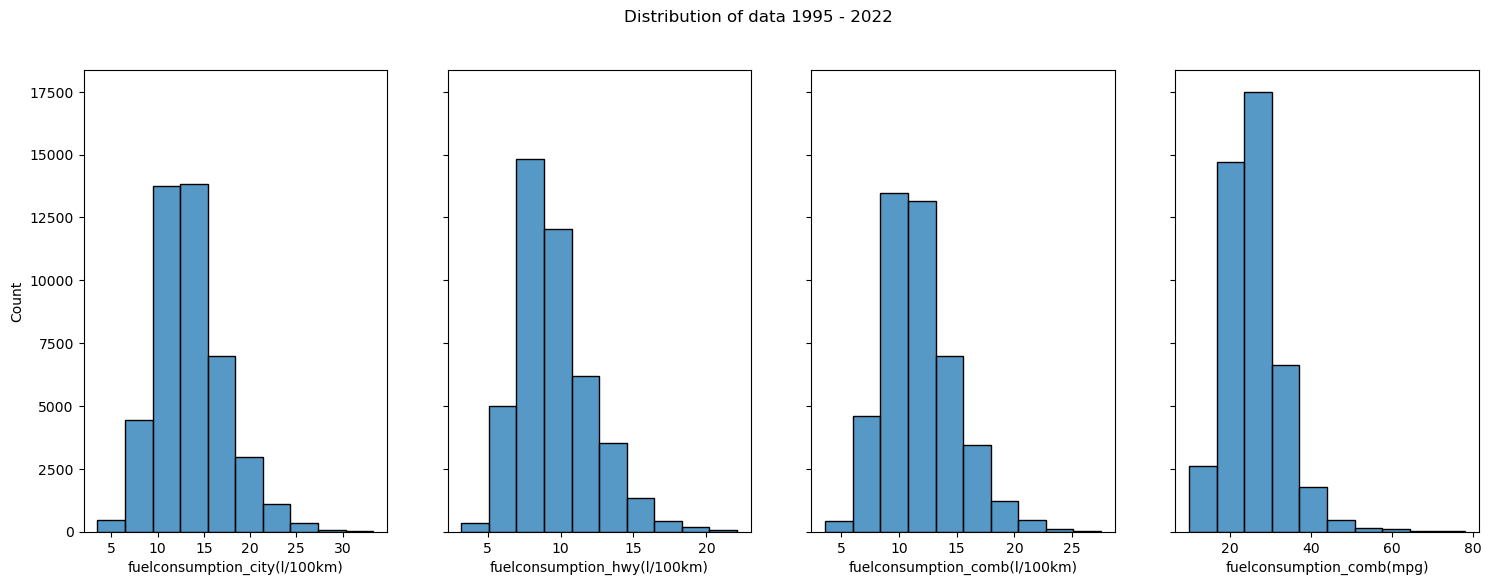

In [22]:

box_plot(master_df,fuel_info,"hist")

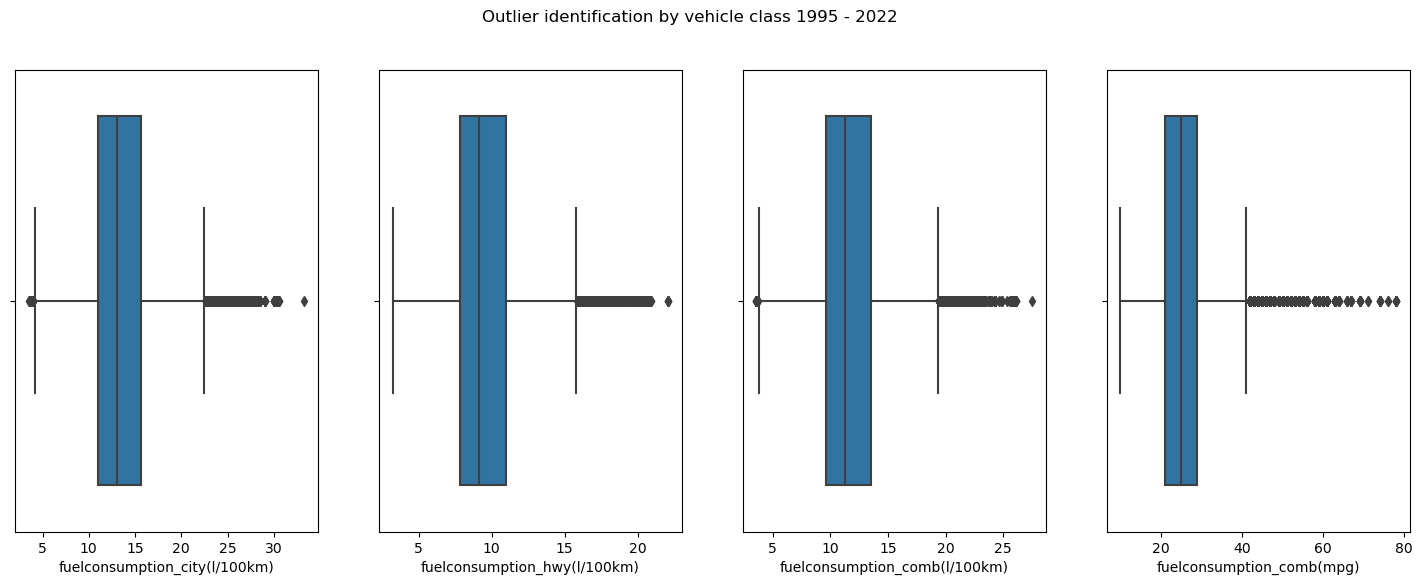

In [23]:
box_plot(master_df,fuel_info,"box")

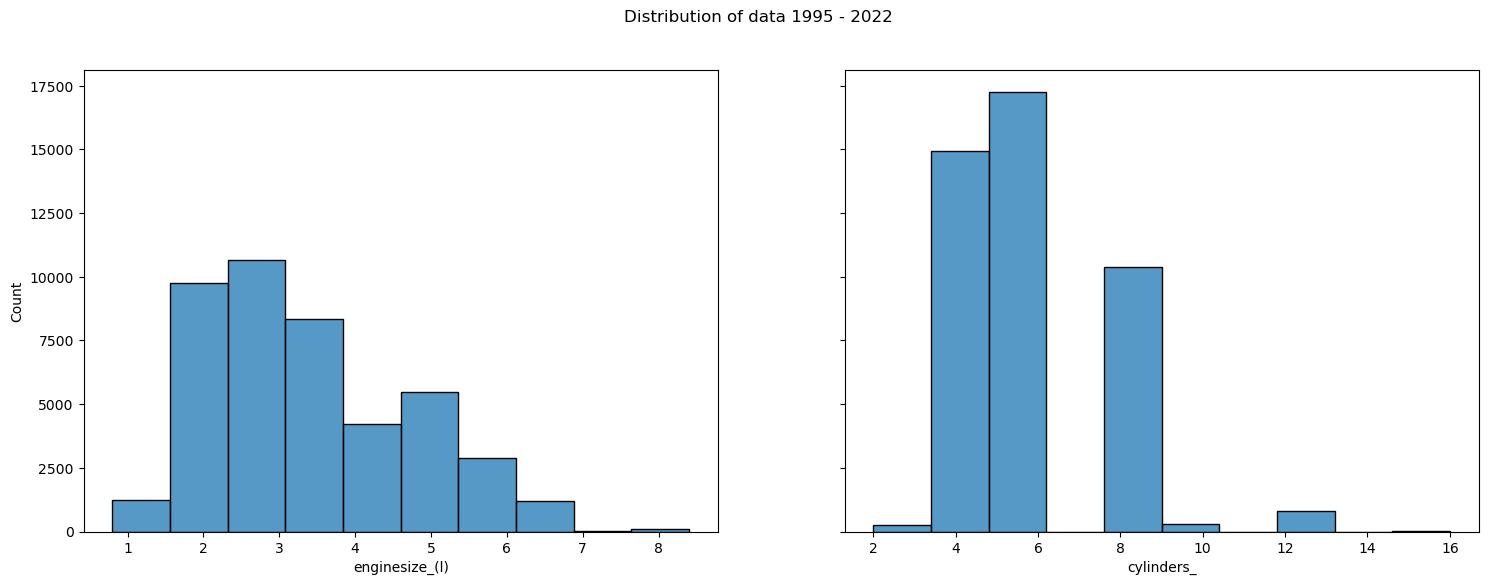

In [24]:
engine_info  = ['EngineSize_(L)','Cylinders_']
box_plot(master_df,engine_info,'hist')

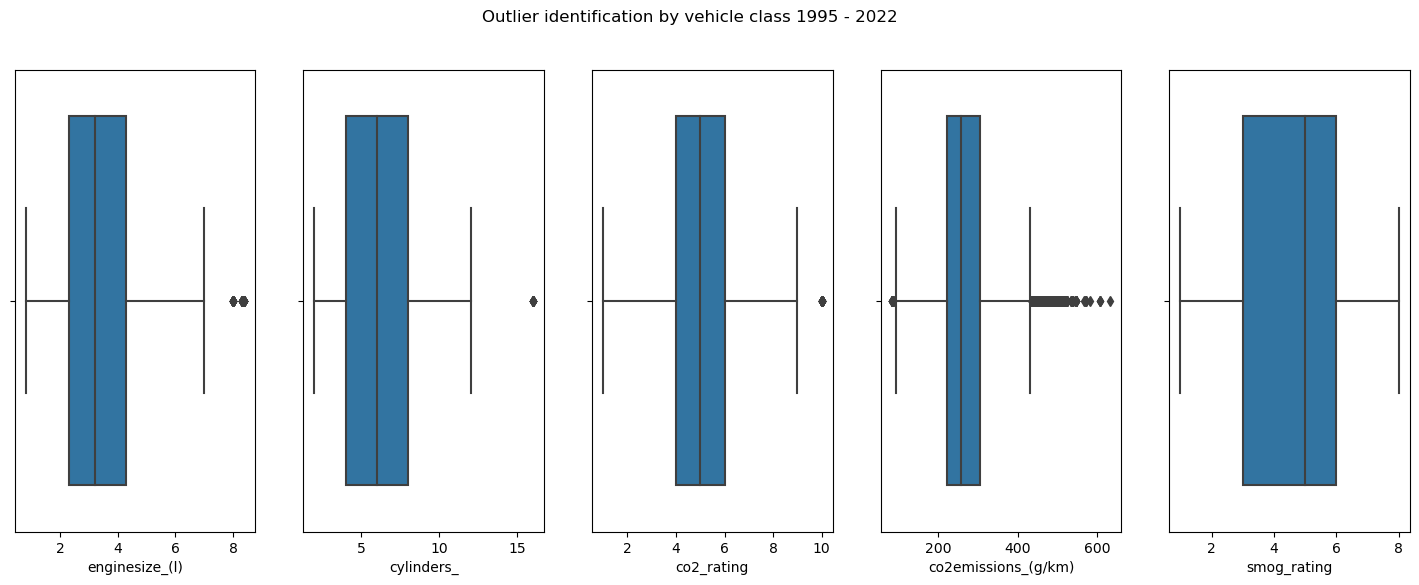

In [25]:
engine_info  = ['EngineSize_(L)','Cylinders_','co2_rating','CO2Emissions_(g/km)','smog_rating']
box_plot(master_df,engine_info,'box')

In [26]:
master_df[~master_df['co2_rating'].isna()]

,model_year,make_,model.1_,vehicleclass_,enginesize_(l),cylinders_,transmission_,fuel_type,fuelconsumption_city(l/100km),fuelconsumption_hwy(l/100km),fuelconsumption_comb(l/100km),fuelconsumption_comb(mpg),co2emissions_(g/km),co2_rating,smog_rating,type_of_wheel_drive,type_of_transmission,type_of_fuel
1,2022,Acura,ILX,Compact,2.4,4.0,AM8,Z,9.9,7.0,8.6,33,200,6.0,3.0,unspecified,automatic,premium gasoline
2,2022,Acura,MDX SH-AWD,SUV: Small,3.5,6.0,AS10,Z,12.6,9.4,11.2,25,263,4.0,5.0,All-wheel drive,automatic,premium gasoline
3,2022,Acura,RDX SH-AWD,SUV: Small,2.0,4.0,AS10,Z,11.0,8.6,9.9,29,232,5.0,6.0,All-wheel drive,automatic,premium gasoline
4,2022,Acura,RDX SH-AWD A-SPEC,SUV: Small,2.0,4.0,AS10,Z,11.3,9.1,10.3,27,242,5.0,6.0,All-wheel drive,automatic,premium gasoline
5,2022,Acura,TLX SH-AWD,Compact,2.0,4.0,AS10,Z,11.2,8.0,9.8,29,230,5.0,7.0,All-wheel drive,automatic,premium gasoline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,2016,VOLVO,XC70 T5,SUV - SMALL,2.0,4.0,AS8,X,10.3,7.6,9.1,31,213,6.0,NaN,unspecified,automatic,regular gasoline
1107,2016,VOLVO,XC70 T5 AWD,SUV - SMALL,2.5,5.0,AS6,X,12.5,9.2,11.0,26,254,5.0,NaN,All-wheel drive,automatic,regular gasoline
1108,2016,VOLVO,XC90 T5,SUV - STANDARD,2.0,4.0,AS8,Z,10.6,9.1,10.0,28,232,5.0,NaN,unspecified,automatic,premium gasoline
1109,2016,VOLVO,XC90 T5 AWD,SUV - STANDARD,2.0,4.0,AS8,Z,10.8,9.5,10.2,28,239,5.0,NaN,All-wheel drive,automatic,premium gasoline


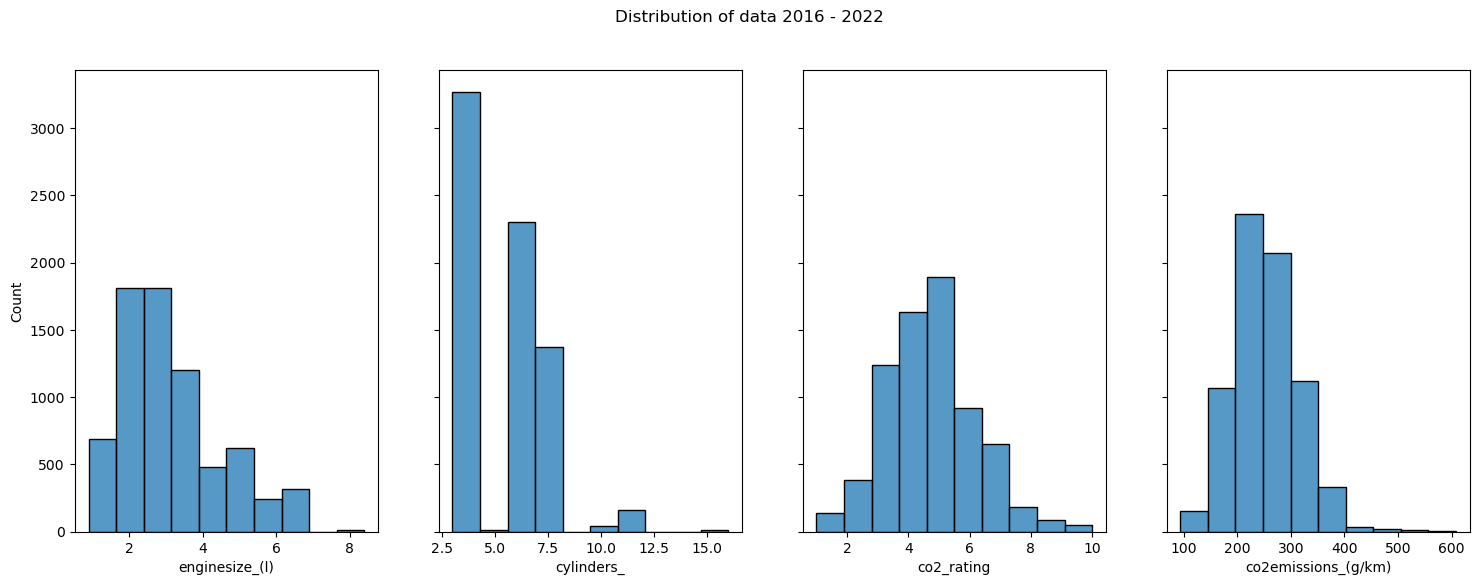

In [27]:
non_na_rating = master_df[~master_df['co2_rating'].isna()]
box_plot(non_na_rating,['EngineSize_(L)','Cylinders_','co2_rating','CO2Emissions_(g/km)'],"hist")

### Using natural logarithm

In [28]:
master_df_log_app = master_df.copy()

In [29]:
fuel_info = [
              'fuelconsumption_city(l/100km)','fuelconsumption_hwy(l/100km)',	
              'fuelconsumption_comb(l/100km)','fuelconsumption_comb(mpg)',]
    
engine_info  = ['enginesize_(l)','co2emissions_(g/km)','smog_rating']

In [30]:
for item in fuel_info:
    master_df_log_app[item] = master_df_log_app[item].apply(lambda x: np.log(x))
    
for item in engine_info:
    master_df_log_app[item] = master_df_log_app[item].apply(lambda x: np.log(x))

In [31]:
master_df_log_app.head()

,model_year,make_,model.1_,vehicleclass_,enginesize_(l),cylinders_,transmission_,fuel_type,fuelconsumption_city(l/100km),fuelconsumption_hwy(l/100km),fuelconsumption_comb(l/100km),fuelconsumption_comb(mpg),co2emissions_(g/km),co2_rating,smog_rating,type_of_wheel_drive,type_of_transmission,type_of_fuel
1,2022,Acura,ILX,Compact,0.875469,4.0,AM8,Z,2.292535,1.945910,2.151762,3.496508,5.298317,6.0,1.098612,unspecified,automatic,premium gasoline
2,2022,Acura,MDX SH-AWD,SUV: Small,1.252763,6.0,AS10,Z,2.533697,2.240710,2.415914,3.218876,5.572154,4.0,1.609438,All-wheel drive,automatic,premium gasoline
3,2022,Acura,RDX SH-AWD,SUV: Small,0.693147,4.0,AS10,Z,2.397895,2.151762,2.292535,3.367296,5.446737,5.0,1.791759,All-wheel drive,automatic,premium gasoline
4,2022,Acura,RDX SH-AWD A-SPEC,SUV: Small,0.693147,4.0,AS10,Z,2.424803,2.208274,2.332144,3.295837,5.488938,5.0,1.791759,All-wheel drive,automatic,premium gasoline
5,2022,Acura,TLX SH-AWD,Compact,0.693147,4.0,AS10,Z,2.415914,2.079442,2.282382,3.367296,5.438079,5.0,1.945910,All-wheel drive,automatic,premium gasoline


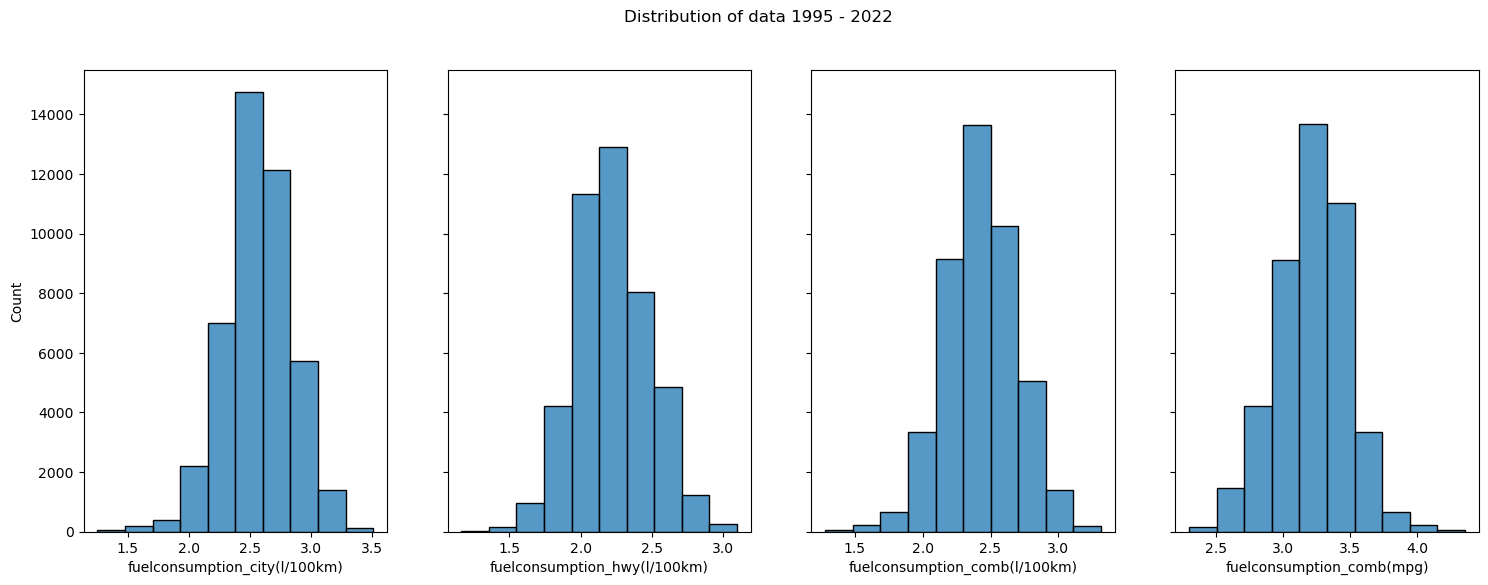

In [32]:
box_plot(master_df_log_app,fuel_info,"hist")


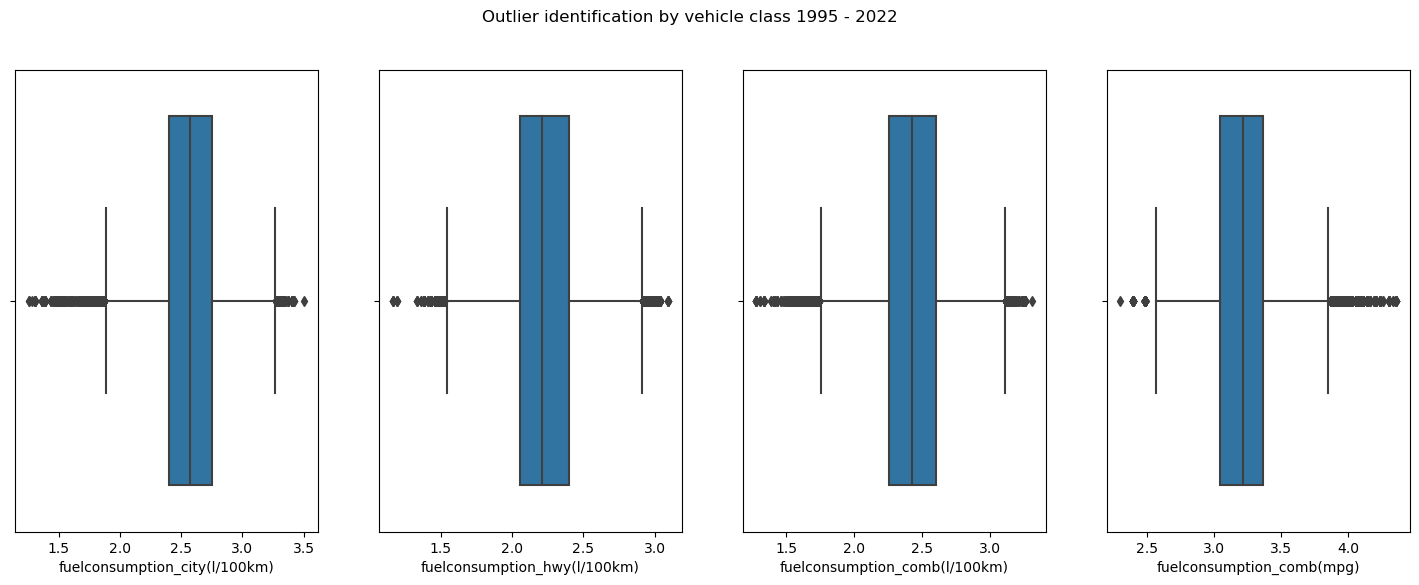

In [33]:
box_plot(master_df_log_app,fuel_info,"box")

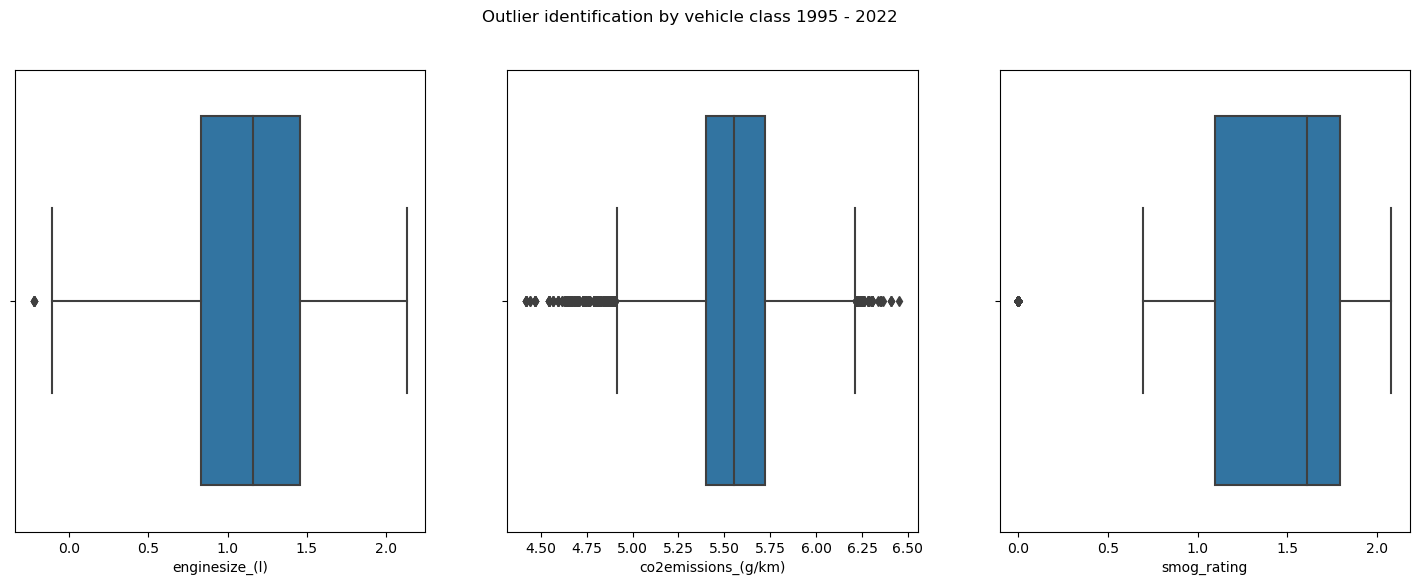

In [34]:
box_plot(master_df_log_app,engine_info,"box")

In [35]:
outliers_log = {}
for item in fuel_info:
    outliers[item] = np.sort(find_outliers_tukey(master_df_log_app[item]))
    print(item, len(outliers[item]))
    
for item in ['enginesize_(l)','cylinders_','co2_rating','co2emissions_(g/km)']:
    outliers[item] = np.sort(find_outliers_tukey(master_df_log_app[item]))
    print(item, len(outliers[item]))

fuelconsumption_city(l/100km) 4443
fuelconsumption_hwy(l/100km) 2425
fuelconsumption_comb(l/100km) 3743
fuelconsumption_comb(mpg) 4288
enginesize_(l) 31
cylinders_ 155
co2_rating 0
co2emissions_(g/km) 3057


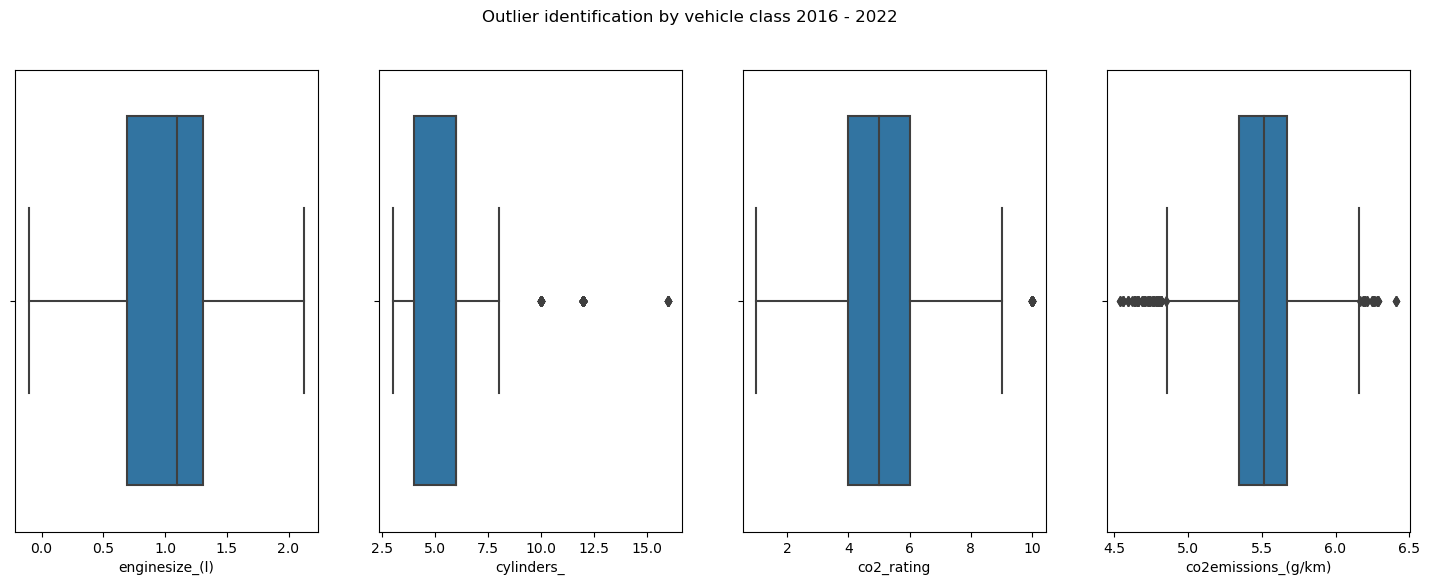

In [36]:
non_na_rating_log = master_df_log_app[~master_df_log_app['co2_rating'].isna()]
box_plot(non_na_rating_log,['EngineSize_(L)','Cylinders_','co2_rating','CO2Emissions_(g/km)'],"box")

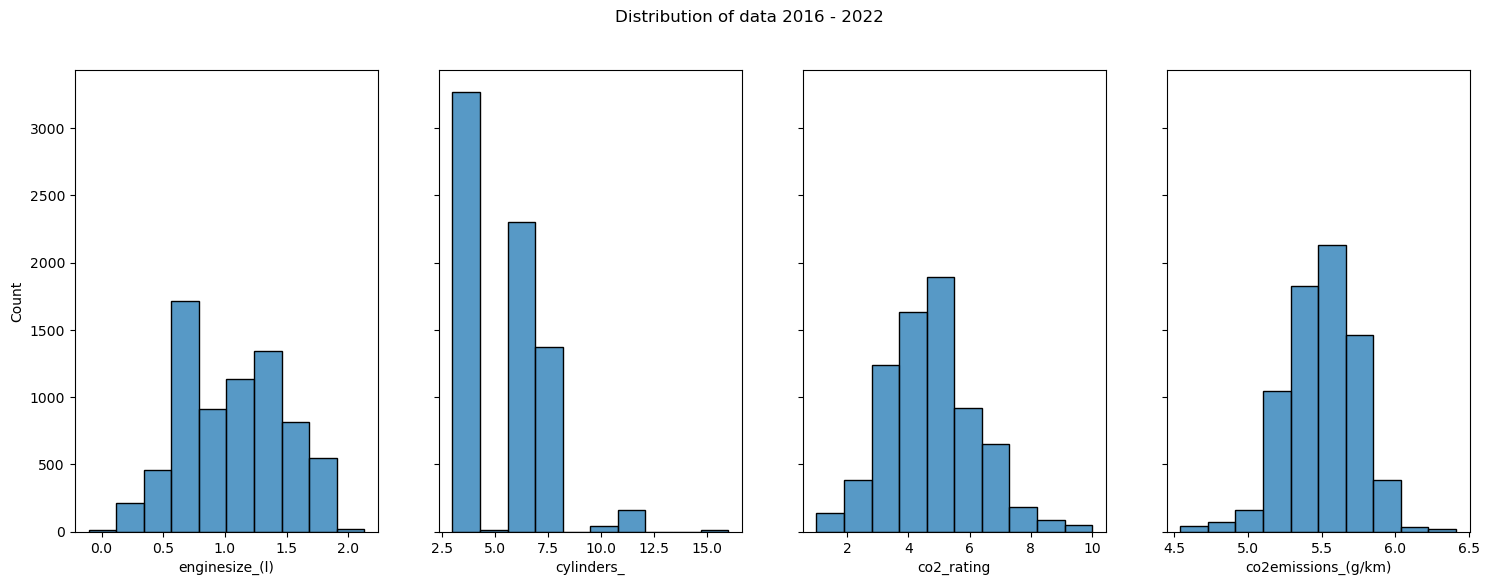

In [37]:
box_plot(non_na_rating_log,['EngineSize_(L)','Cylinders_','co2_rating','CO2Emissions_(g/km)'],"hist")

In [109]:
corr_matrix_non_na_log = non_na_rating_log.corr()

corr_matrix = master_df.corr()

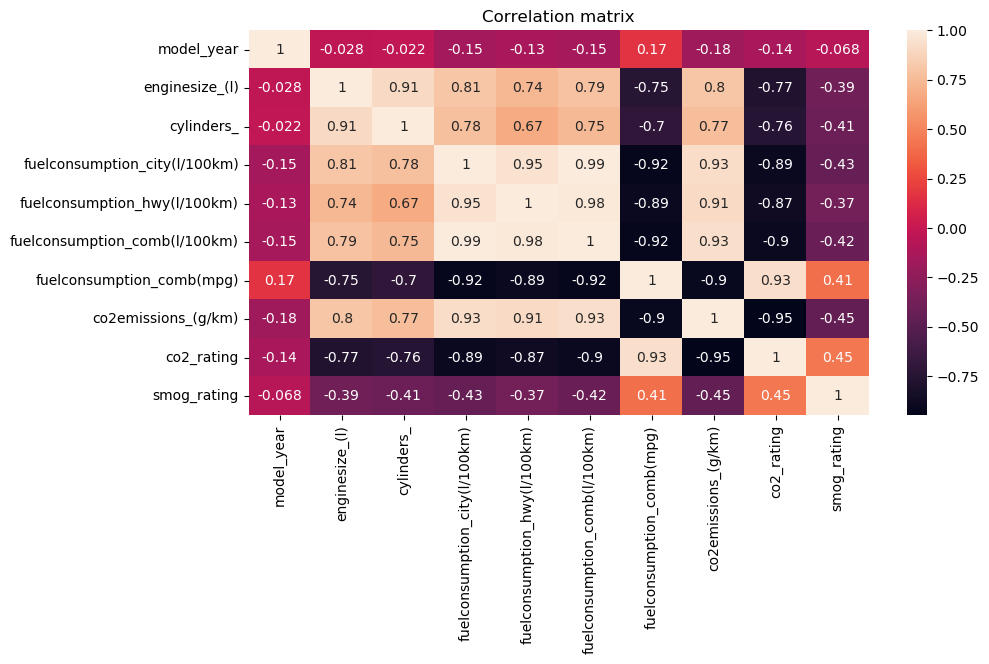

In [117]:
fig_corr = sns.heatmap(corr_matrix, annot=True)
fig_corr.figure.savefig("./plots/correlation_matrix.png") 
plt.title("Correlation matrix")
plt.show()

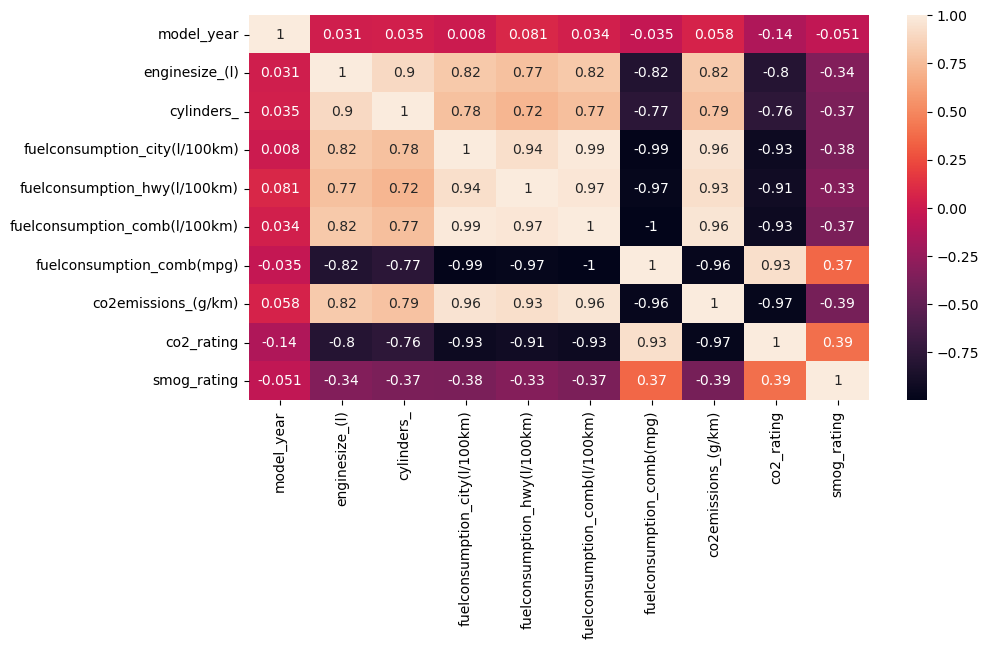

In [113]:
sns.heatmap(corr_matrix_non_na_log, annot=True)

plt.show()

## Predicting CO2 ratings for remaining values - feature engineering

#### Target variable: co2_rating

#### Independent variables: 

1. engine_size(l),

2. fuelconsumption_city(l/100km), 

3. fuelconsumption_hwy(l/100km),

4. fuelconsumption_comb(l/100km),

5. fuelconsumption_comb(mpg)

6. co2emissions_(g/km)

7. (maybe) cylinders_ 

In [83]:
entries_with_scores = master_df_log_app[master_df_log_app['model_year']>=2017]
entries_with_scores.isna().sum()

model_year                       0
make_                            0
model.1_                         0
vehicleclass_                    0
enginesize_(l)                   0
cylinders_                       0
transmission_                    0
fuel_type                        0
fuelconsumption_city(l/100km)    0
fuelconsumption_hwy(l/100km)     0
fuelconsumption_comb(l/100km)    0
fuelconsumption_comb(mpg)        0
co2emissions_(g/km)              0
co2_rating                       0
smog_rating                      0
type_of_wheel_drive              0
type_of_transmission             0
type_of_fuel                     0
dtype: int64

In [39]:
#fig = sns.pairplot(entries_with_scores, hue="type_of_fuel")
#fig.savefig("./plots/pairplot-by-fuel-type.png") 
#plt.show()

In [132]:
#entries_with_scores['co2_rating'] = entries_with_scores['co2_rating'].astype('int').astype('str')

In [84]:
entries_with_scores['co2_rating']

1       6.0
2       4.0
3       5.0
4       5.0
5       5.0
       ... 
1054    5.0
1055    5.0
1056    5.0
1057    5.0
1058    5.0
Name: co2_rating, Length: 6061, dtype: float64

In [131]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.compose import make_column_transformer

kf = KFold(n_splits=10)
folds = StratifiedGroupKFold(n_splits=10)

def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [118]:
Y = entries_with_scores['co2_rating']

X = entries_with_scores[['enginesize_(l)','cylinders_','fuelconsumption_city(l/100km)',
                         'fuelconsumption_hwy(l/100km)', 'fuelconsumption_comb(l/100km)', 
                         'fuelconsumption_comb(mpg)','co2emissions_(g/km)']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

In [120]:
lr_sc = []
sv_sc = []
rf_sc = []
for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index],\
                                        Y.iloc[train_index], Y.iloc[test_index] 
    lr_sc.append(get_score(LinearRegression(), X_train, X_test, y_train, y_test))
    
    ### NEED TO REVIEW https://scikit-learn.org/stable/modules/preprocessing.html
    sv_sc.append(get_score(GradientBoostingRegressor(), X_train, X_test, y_train, y_test))
    rf_sc.append(get_score(RandomForestClassifier(), X_train, X_test, y_train, y_test))

In [121]:
lr_sc

[0.9041386924324565,
 0.9384440411936109,
 0.9527157162558509,
 0.9565889003245229,
 0.9561415613979364,
 0.9598559645378568,
 0.9516065469516524,
 0.9569052643535199,
 0.943098135564088,
 0.9482230866010175]

In [122]:
sv_sc

[0.9064263287095182,
 0.9493372911309348,
 0.9755872922788822,
 0.980953895136175,
 0.9836204402224064,
 0.9843786811447506,
 0.9841077586917619,
 0.9841565786098521,
 0.9477344489830372,
 0.9439213377095547]

In [123]:
rf_sc

[0.7479406919275123,
 0.8267326732673267,
 0.8514851485148515,
 0.9323432343234324,
 0.9389438943894389,
 0.9504950495049505,
 0.9108910891089109,
 0.9174917491749175,
 0.7953795379537953,
 0.7788778877887789]

In [124]:
cross_val_score(LinearRegression(), X, Y)

array([0.91444997, 0.95339313, 0.95731916, 0.95292023, 0.943201  ])

In [125]:
cross_val_score(GradientBoostingRegressor(n_estimators=40), X, Y)

array([0.92360874, 0.97604207, 0.97937002, 0.97871753, 0.93495789])

In [126]:
cross_val_score(RandomForestClassifier(n_estimators=100), X, Y)

array([0.76257214, 0.89686469, 0.94636964, 0.91749175, 0.79867987])

#### Predicting

In [127]:
lm = LinearRegression()
lm.fit(X_train, y_train)
lm_predictions = lm.predict(X_test)


gbm = GradientBoostingRegressor()
gbm.fit(X_train, y_train)
gmb_predictions = gbm.predict(X_test)

In [128]:
lm_mae = mean_absolute_error(lm_predictions, y_test)
# lm_rmse = np.sqrt(mean_squared_error(lm_predictions, y_test),y_test)

gbm_mae = mean_absolute_error(gmb_predictions, y_test)
# gbm_rmse = np.sqrt(mean_squared_error(gmb_predictions, y_test), y_test)

In [129]:
print(lm_mae)
print(gbm_mae)

0.31934997237507
0.23298170150286238


GradientBoostingRegressor is slightly more accurate than gradient boosting.

In [130]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, gmb_predictions)

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets